** 이번주: IMAGENET의 모듈 시도 **

*   이미지 전처리는 저번주 실습을 토대로 작성
*   각자 한 모듈의 시리즈를 맡아 진행
*   기본 조건 동결: 
>             image_shape = (180, 180, 3)
>                   batch_size = 32
>                  train_split = 0.2
>         epoch = 시도해볼 때는 10 -> 최종모델은 30





# 1. 데이터 로드

모두 같은 방식으로 데이터 로드, 이미지 전처리부터 각자 방식 사용





In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras import utils
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten, Input, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

In [ ]:
train_x = np.load("/content/drive/MyDrive/Parrot_competition/simpson_train_x_150.npy")
train_y = np.load("/content/drive/MyDrive/Parrot_competition/simpson_train_y_150.npy")
num_classes = train_y.shape[1]
print(train_x.shape)
print(train_y.shape)
print(num_classes)

(11248, 150, 150, 3)
(11248, 9)
9


In [ ]:
class_names = ['bart', 'charles_montgomery', 'krusty', 'lisa_simpson', 'marge_simpson', 'milhouse_van_houten', 'moe_szyslak', 'ned_flanders', 'principal_skinner']

In [ ]:
size = 150
batch_size = 32

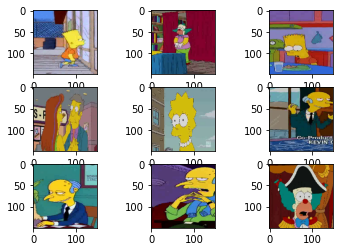

In [ ]:
def draw_data(data, axis = 5):
    len_data = len(data)
    size = axis**2
    random_int = np.random.randint(low=0, high=len_data, size=size)
    for i in range(0,size):
        plt.subplot(axis,axis,i+1)
        plt.imshow(data[i], cmap=plt.get_cmap('Purples'))

    plt.show()

draw_data(train_x, 3)

In [ ]:
def acc_loss_plot(hist):
    fig, loss_ax = plt.subplots()
    acc_ax = loss_ax.twinx()

    loss_ax.plot(hist.history['loss'], 'y', label='train loss')
    loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
    loss_ax.set_xlabel('epoch')
    loss_ax.set_ylabel('loss')
    loss_ax.legend(loc = 'upper left')

    acc_ax.plot(hist.history['accuracy'], 'b', label='train acc')
    acc_ax.plot(hist.history['val_accuracy'], 'g', label='val acc')
    acc_ax.set_ylabel('accuracy')
    acc_ax.legend(loc='upper right')

    plt.show()

# 이미지 전처리




*   Imagedatagenerator과 data_augmentation Sequential 층 깔아주는 방법 두가지
*   두 방법 다 쓴 사람이 있고 하나만 쓴 사람도 있다!





In [ ]:
data_augmentation = keras.Sequential(
  [ layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(size,size, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomWidth(0.1),
    layers.experimental.preprocessing.RandomHeight(0.1)]
    )

In [ ]:
datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False, 
        zca_whitening=False,  
        rotation_range=10, 
        zoom_range = 0.1,
        width_shift_range=0.1, 
        height_shift_range=0.1,
        horizontal_flip=False, 
        vertical_flip=True)

datagen.fit(train_x) 

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(train_x, train_y, test_size = 0.2, random_state=1)

# 황선애

**MoblieNetV2 사용**

**MobileNet : Mobile,embedded,computers without gpu**

---
저조한 컴퓨터 환경(속도, 전력, gpu 없는..)에서 사용될 수 있게 cnn을 변형시킨 것.
성능대신에 속도를 선택한 모델인것 같다.


In [ ]:
def build_model_mobilenet(num_classes):
    # MobileNetV2 신경망 로드
    model=tf.keras.applications.MobileNetV2(input_shape=(size,size,3), include_top=False, weights='imagenet')
    model.trainable=False
    #처음의 입력 데이터 만들기
    inputs = layers.Input(shape=(size, size, 3))
    #Dense레이어 Global Average Pool 만들기
    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    dropout = 0.4
    x = layers.Dropout(dropout, name="top_dropout")(x)
    #최종 분류 레이어 만들기
    output = layers.Dense(num_classes, activation="softmax", name="pred")(x)
    model = Model(inputs = model.input, outputs = output)

    return model 

In [ ]:
#모델 빌드/컴파일
model1=build_model_mobilenet(num_classes)
optimizer=tf.keras.optimizers.Adam()
model1.compile(optimizer=optimizer,loss=tf.keras.losses.categorical_crossentropy,metrics=["accuracy"])
model1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 151, 151, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________________

In [ ]:
hist1=model1.fit(datagen.flow(x_train, y_train,batch_size=batch_size),
                 steps_per_epoch=len(x_train)/batch_size, 
                 epochs=10,validation_data=(x_val,y_val))

Epoch 1/10
282/281 [==============================] - 44s 154ms/step - loss: 1.9982 - accuracy: 0.3721 - val_loss: 1.3065 - val_accuracy: 0.5662
Epoch 2/10
282/281 [==============================] - 43s 152ms/step - loss: 1.4489 - accuracy: 0.5333 - val_loss: 1.2250 - val_accuracy: 0.6044
Epoch 3/10
282/281 [==============================] - 43s 152ms/step - loss: 1.3304 - accuracy: 0.5670 - val_loss: 1.1229 - val_accuracy: 0.6240
Epoch 4/10
282/281 [==============================] - 44s 155ms/step - loss: 1.2867 - accuracy: 0.5776 - val_loss: 1.1070 - val_accuracy: 0.6396
Epoch 5/10
282/281 [==============================] - 44s 155ms/step - loss: 1.2520 - accuracy: 0.5864 - val_loss: 1.1003 - val_accuracy: 0.6471
Epoch 6/10
282/281 [==============================] - 44s 156ms/step - loss: 1.2228 - accuracy: 0.5935 - val_loss: 1.0840 - val_accuracy: 0.6493
Epoch 7/10
282/281 [==============================] - 44s 157ms/step - loss: 1.2285 - accuracy: 0.5947 - val_loss: 1.0741 - val_ac

MoblieNet CNN Accuracy


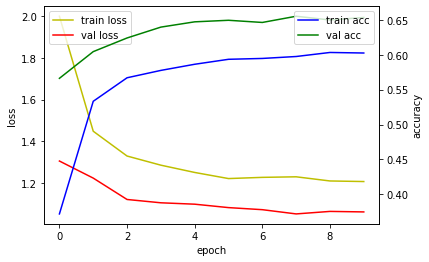

In [ ]:
print("MoblieNet CNN Accuracy")
acc_loss_plot(hist1)

# 이영인

**DenseNet121 사용**

In [ ]:
from tensorflow.keras.applications import DenseNet121

In [ ]:
def build_model_densenet(num_classes):

    inputs = layers.Input(shape=(size, size, 3))
    x = data_augmentation(inputs)
    model = DenseNet121(include_top=False, weights="imagenet", input_tensor=x)

    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.5
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(model.inputs, outputs, name="DenseNet121")

    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [ ]:
model2 = build_model_densenet(num_classes)

In [ ]:
hist2 = model2.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                 steps_per_epoch=len(x_train)/batch_size, 
                 epochs=10,validation_data=(x_val, y_val))

Epoch 1/10
282/281 [==============================] - 62s 220ms/step - loss: 2.3979 - accuracy: 0.2316 - val_loss: 1.4440 - val_accuracy: 0.4991
Epoch 2/10
282/281 [==============================] - 52s 185ms/step - loss: 1.6710 - accuracy: 0.4435 - val_loss: 1.1098 - val_accuracy: 0.6440
Epoch 3/10
282/281 [==============================] - 51s 179ms/step - loss: 1.3263 - accuracy: 0.5598 - val_loss: 0.8548 - val_accuracy: 0.7413
Epoch 4/10
282/281 [==============================] - 49s 175ms/step - loss: 1.1289 - accuracy: 0.6300 - val_loss: 0.6960 - val_accuracy: 0.7947
Epoch 5/10
282/281 [==============================] - 49s 173ms/step - loss: 0.9848 - accuracy: 0.6817 - val_loss: 0.6301 - val_accuracy: 0.8111
Epoch 6/10
282/281 [==============================] - 49s 173ms/step - loss: 0.8773 - accuracy: 0.7155 - val_loss: 0.5583 - val_accuracy: 0.8302
Epoch 7/10
282/281 [==============================] - 48s 171ms/step - loss: 0.7818 - accuracy: 0.7475 - val_loss: 0.4949 - val_ac

DenseNet CNN Accuracy


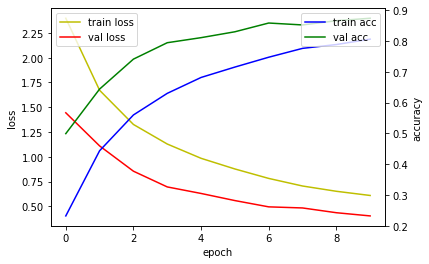

In [ ]:
print("DenseNet CNN Accuracy")
acc_loss_plot(hist2)

**------DenseNet201이 정확도가 더 높아 DenseNet201로 test지 제출------**

# 정상희

**InceptionV3 사용**

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [ ]:
def build_model_inception(num_classes):

    inputs = layers.Input(shape=(size, size, 3))
    x = data_augmentation(inputs)
    model = InceptionV3(include_top=False, weights="imagenet", classes=num_classes)

     # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)
    dropout = 0.4
    x = layers.Dropout(dropout, name="top_dropout")(x)

    output = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    model = Model(inputs = model.input, outputs = output, name = 'InceptionV3')

    return model

In [ ]:
model3 = build_model_inception(num_classes)

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model3.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

model3.summary()

Model: "InceptionV3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_5[0][0]                    
__________________________________________________________________________________________________
batch_normalization_2 (BatchNor (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization_2[0][0]      
________________________________________________________________________________________

In [ ]:
hist3 = model3.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                 steps_per_epoch=len(x_train)/batch_size, 
                 epochs=10,validation_data=(x_val, y_val))

Epoch 1/10
282/281 [==============================] - 55s 194ms/step - loss: 1.3440 - accuracy: 0.5921 - val_loss: 0.4578 - val_accuracy: 0.8653
Epoch 2/10
282/281 [==============================] - 53s 188ms/step - loss: 0.4506 - accuracy: 0.8606 - val_loss: 0.2908 - val_accuracy: 0.9178
Epoch 3/10
282/281 [==============================] - 53s 189ms/step - loss: 0.2795 - accuracy: 0.9132 - val_loss: 0.2157 - val_accuracy: 0.9364
Epoch 4/10
282/281 [==============================] - 53s 190ms/step - loss: 0.2057 - accuracy: 0.9357 - val_loss: 0.2118 - val_accuracy: 0.9431
Epoch 5/10
282/281 [==============================] - 53s 189ms/step - loss: 0.1557 - accuracy: 0.9490 - val_loss: 0.1762 - val_accuracy: 0.9578
Epoch 6/10
282/281 [==============================] - 54s 192ms/step - loss: 0.1338 - accuracy: 0.9591 - val_loss: 0.1870 - val_accuracy: 0.9533
Epoch 7/10
282/281 [==============================] - 55s 194ms/step - loss: 0.1183 - accuracy: 0.9623 - val_loss: 0.1661 - val_ac

Inception CNN Accuracy


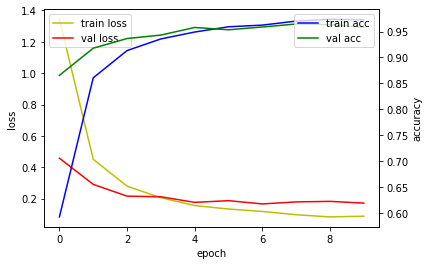

In [ ]:
print("Inception CNN Accuracy")
acc_loss_plot(hist3)

**InceptionV3 Fine tuning(전이학습)**

*  최상위 레이어들을 동결시켜서 직접 만든 층을 쌓고 훈련시킨 다음, 특정 깊이의 층만큼 unfreeze할 것이다.

>  https://keras.io/api/applications/ 이 쪽에서 설명해주는 방법

>  자율 학습 시키기 -> N개의 하층 레이어들을 freeze시키고 나머지를 unfreeze하는 내용이다.



In [ ]:
base_model = InceptionV3(weights='imagenet', include_top=False)

for layer in base_model.layers:
  layer.trainable = False

pool_2d = GlobalAveragePooling2D(name='pool_2d')(base_model.output)
batch_normal = BatchNormalization(name='batch_normal')(pool_2d)
dropout = Dropout(0.4, name='dropout')(batch_normal)
dense = Dense(1024, name='dense', activation='relu')(dropout)
predictions = Dense(num_classes, activation='softmax')(dense)
model3_2 = Model(inputs=base_model.input, outputs=predictions)
model3_2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history1 = model3_2.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                 steps_per_epoch=len(x_train)/batch_size, 
                 epochs=10,validation_data=(x_val, y_val))

Epoch 1/10
282/281 [==============================] - 50s 176ms/step - loss: 2.3782 - accuracy: 0.4218 - val_loss: 1.3671 - val_accuracy: 0.5858
Epoch 2/10
282/281 [==============================] - 48s 170ms/step - loss: 1.5511 - accuracy: 0.5191 - val_loss: 1.2399 - val_accuracy: 0.6000
Epoch 3/10
282/281 [==============================] - 49s 172ms/step - loss: 1.3720 - accuracy: 0.5510 - val_loss: 1.0616 - val_accuracy: 0.6502
Epoch 4/10
282/281 [==============================] - 49s 172ms/step - loss: 1.2418 - accuracy: 0.5802 - val_loss: 1.0589 - val_accuracy: 0.6502
Epoch 5/10
282/281 [==============================] - 49s 173ms/step - loss: 1.2359 - accuracy: 0.5839 - val_loss: 1.0587 - val_accuracy: 0.6587
Epoch 6/10
282/281 [==============================] - 49s 173ms/step - loss: 1.1746 - accuracy: 0.6017 - val_loss: 1.0252 - val_accuracy: 0.6667
Epoch 7/10
282/281 [==============================] - 49s 172ms/step - loss: 1.1250 - accuracy: 0.6176 - val_loss: 0.9935 - val_ac

In [ ]:
# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model3_2.layers[:249]:
   layer.trainable = False
for layer in model3_2.layers[249:]:
   layer.trainable = True

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)

model3_2.compile(optimizer=optimizer,
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

In [ ]:
history2 = model3_2.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
                 steps_per_epoch=len(x_train)/batch_size, 
                 epochs=10,validation_data=(x_val, y_val))

Epoch 1/10
282/281 [==============================] - 49s 175ms/step - loss: 1.1624 - accuracy: 0.6140 - val_loss: 0.8565 - val_accuracy: 0.7351
Epoch 2/10
282/281 [==============================] - 48s 170ms/step - loss: 0.7901 - accuracy: 0.7445 - val_loss: 0.6828 - val_accuracy: 0.7898
Epoch 3/10
282/281 [==============================] - 48s 169ms/step - loss: 0.6375 - accuracy: 0.7911 - val_loss: 0.6175 - val_accuracy: 0.8133
Epoch 4/10
282/281 [==============================] - 48s 169ms/step - loss: 0.5414 - accuracy: 0.8260 - val_loss: 0.5595 - val_accuracy: 0.8391
Epoch 5/10
282/281 [==============================] - 48s 170ms/step - loss: 0.4584 - accuracy: 0.8502 - val_loss: 0.5279 - val_accuracy: 0.8502
Epoch 6/10
282/281 [==============================] - 48s 170ms/step - loss: 0.4073 - accuracy: 0.8660 - val_loss: 0.4991 - val_accuracy: 0.8507
Epoch 7/10
282/281 [==============================] - 48s 169ms/step - loss: 0.3577 - accuracy: 0.8841 - val_loss: 0.4661 - val_ac

Inception fine tuning CNN Accuracy


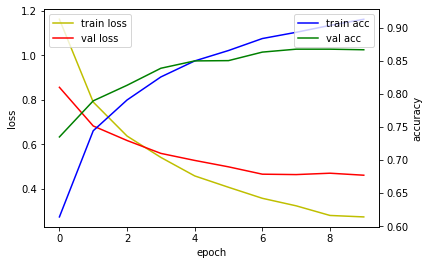

In [ ]:
print("Inception fine tuning CNN Accuracy")
acc_loss_plot(history2)

# 최보영

**VGG19 사용**

In [ ]:
dropout_rate = 0.2 
learning_rate = 1e-5
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

In [ ]:
from tensorflow.keras.applications.vgg19 import VGG19

In [ ]:
def build_model_vgg19(num_classes):

    inputs = layers.Input(shape=(size, size, 3))
    model = VGG19(include_top=False, weights="imagenet")
    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    dropout = dropout_rate
    x = layers.Dropout(dropout, name="top_dropout")(x)
    output = layers.Dense(num_classes, activation="softmax", name="pred")(x)
    model = Model(inputs = model.input, outputs = output)

    return model

model4_1 = build_model_vgg19(num_classes)

for layer in model4_1.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model4_1.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

model4_1.summary()

Model: "functional_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)  

In [ ]:
hist4_1 = model4_1.fit(datagen.flow(x_train, y_train), batch_size=batch_size
                       ,steps_per_epoch=len(x_train) / batch_size, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
282/281 [==============================] - 79s 282ms/step - loss: 1.5111 - accuracy: 0.4920 - val_loss: 1.1351 - val_accuracy: 0.7040
Epoch 2/10
282/281 [==============================] - 80s 284ms/step - loss: 0.6353 - accuracy: 0.8116 - val_loss: 0.4427 - val_accuracy: 0.8658
Epoch 3/10
282/281 [==============================] - 80s 284ms/step - loss: 0.3726 - accuracy: 0.8920 - val_loss: 0.4630 - val_accuracy: 0.8582
Epoch 4/10
282/281 [==============================] - 80s 284ms/step - loss: 0.2617 - accuracy: 0.9201 - val_loss: 0.2073 - val_accuracy: 0.9364
Epoch 5/10
282/281 [==============================] - 80s 284ms/step - loss: 0.2006 - accuracy: 0.9410 - val_loss: 0.3389 - val_accuracy: 0.8947
Epoch 6/10
282/281 [==============================] - 80s 284ms/step - loss: 0.1587 - accuracy: 0.9507 - val_loss: 0.1708 - val_accuracy: 0.9471
Epoch 7/10
282/281 [==============================] - 80s 285ms/step - loss: 0.1248 - accuracy: 0.9624 - val_loss: 0.1870 - val_ac

VGG19 CNN Accuracy


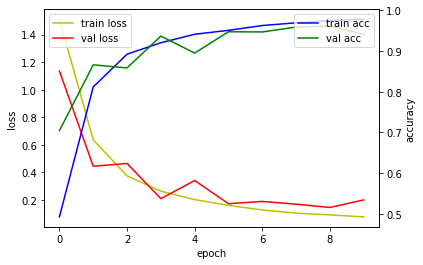

In [ ]:
print("VGG19 CNN Accuracy")
acc_loss_plot(hist4_1)

**VGG16 사용**

In [ ]:
dropout_rate = 0.2 
learning_rate = 1e-5
optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16 

In [ ]:
def build_model_vgg16(num_classes):

    inputs = layers.Input(shape=(size, size, 3))
    model = VGG16(include_top=False, weights="imagenet")
    x = model.output
    x = GlobalAveragePooling2D()(x)
    x = layers.BatchNormalization()(x)
    dropout = dropout_rate
    x = layers.Dropout(dropout, name="top_dropout")(x)
    output = layers.Dense(num_classes, activation="softmax", name="pred")(x)
    model = Model(inputs = model.input, outputs = output)

    return model

model4_2 = build_model_vgg16(num_classes)

for layer in model4_2.layers[-20:]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = True

model4_2.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

model4_2.summary()

58892288/58889256 [==============================] - 0s 0us/step
Model: "functional_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_______________________________________________________

In [ ]:
hist4_2 = model4_2.fit(datagen.flow(x_train, y_train), batch_size=batch_size,
          steps_per_epoch=len(x_train) / batch_size, epochs=10, validation_data=(x_val, y_val))

Epoch 1/10
282/281 [==============================] - 71s 252ms/step - loss: 1.4500 - accuracy: 0.5163 - val_loss: 0.9515 - val_accuracy: 0.7791
Epoch 2/10
282/281 [==============================] - 70s 249ms/step - loss: 0.6141 - accuracy: 0.8172 - val_loss: 0.5277 - val_accuracy: 0.8253
Epoch 3/10
282/281 [==============================] - 70s 247ms/step - loss: 0.3789 - accuracy: 0.8852 - val_loss: 0.3095 - val_accuracy: 0.9124
Epoch 4/10
282/281 [==============================] - 69s 246ms/step - loss: 0.2664 - accuracy: 0.9203 - val_loss: 0.2293 - val_accuracy: 0.9329
Epoch 5/10
282/281 [==============================] - 70s 248ms/step - loss: 0.2100 - accuracy: 0.9367 - val_loss: 0.2464 - val_accuracy: 0.9280
Epoch 6/10
282/281 [==============================] - 70s 246ms/step - loss: 0.1615 - accuracy: 0.9538 - val_loss: 0.1798 - val_accuracy: 0.9467
Epoch 7/10
282/281 [==============================] - 69s 246ms/step - loss: 0.1279 - accuracy: 0.9633 - val_loss: 0.1691 - val_ac

VGG16 CNN Accuracy


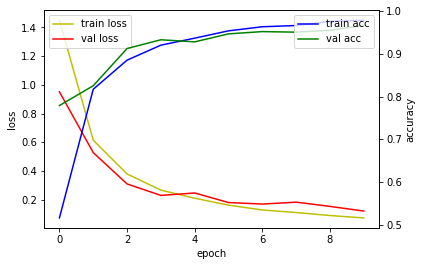

In [ ]:
print("VGG16 CNN Accuracy")
acc_loss_plot(hist4_2)

# 김민지

**ResNet50V2 사용**

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
from tensorflow.keras.applications import ResNet50V2

In [ ]:
def build_model_resnet(num_classes):

    inputs = layers.Input(shape=(size, size, 3))
    x = data_augmentation(inputs)
    model = ResNet50V2(include_top=False, weights="imagenet", input_tensor=x)

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.BatchNormalization()(x)

    top_dropout_rate = 0.4
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(model.inputs, outputs, name="ResNet50V2")

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )
    return model

In [ ]:
model5 = build_model_resnet(num_classes)

94674944/94668760 [==============================] - 0s 0us/step


In [ ]:
hist5 = model5.fit(datagen.flow(x_train, y_train, batch_size=batch_size),
          steps_per_epoch=len(x_train) / batch_size, epochs=10, verbose=1, validation_data=(x_val, y_val))

Epoch 1/10
282/281 [==============================] - 81s 289ms/step - loss: 1.3391 - accuracy: 0.5834 - val_loss: 0.5675 - val_accuracy: 0.8262
Epoch 2/10
282/281 [==============================] - 63s 222ms/step - loss: 0.5412 - accuracy: 0.8367 - val_loss: 0.3728 - val_accuracy: 0.8911
Epoch 3/10
282/281 [==============================] - 62s 218ms/step - loss: 0.3957 - accuracy: 0.8791 - val_loss: 0.2883 - val_accuracy: 0.9227
Epoch 4/10
282/281 [==============================] - 61s 218ms/step - loss: 0.3109 - accuracy: 0.9029 - val_loss: 0.2408 - val_accuracy: 0.9333
Epoch 5/10
282/281 [==============================] - 62s 219ms/step - loss: 0.2457 - accuracy: 0.9250 - val_loss: 0.3102 - val_accuracy: 0.9138
Epoch 6/10
282/281 [==============================] - 61s 218ms/step - loss: 0.2241 - accuracy: 0.9298 - val_loss: 0.2004 - val_accuracy: 0.9440
Epoch 7/10
282/281 [==============================] - 61s 216ms/step - loss: 0.2113 - accuracy: 0.9353 - val_loss: 0.2467 - val_ac

ResNet CNN Accuracy


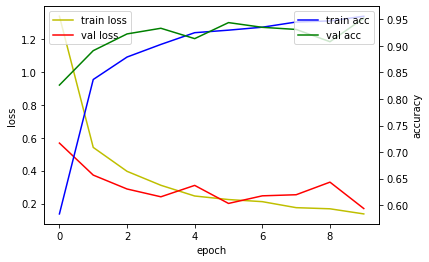

In [ ]:
print("ResNet CNN Accuracy")
acc_loss_plot(hist5)

# Testing & Result

**--epoch 30까지 올리면 MobileNet 제외 거의 97-98%까지 정확도 올라옴--**

**InceptionV3**

1.   Fine Tuning을 한 결과가 모듈을 통째로 돌린 것보다 더 좋지 않다... (전이학습이 항상 좋지만은 않다)
2.   최적의 결과를 위한 하이퍼파라미터

  *   Dropout rate = 0.4
  *   Optimizer = adam(lr=1e-4로 줄이면 변동을 줄이는데 도움이 된다)
3. data augmentation층을 inceptionV3 base model에 추가하면 더 좋다.
4. 전반적으로 다른 모듈들보다 훨씬 빠른편







**VGG series**

1.   VGG19보다는 VGG16의 결과가 더 좋았다.
2.   최적의 결과를 위한 하이퍼파라미터

  *   Dropout rate = 0.2
  *   Optimizer = RMSprop(lr=1e-5로 줄이면 변동을 줄이는데 도움이 된다)
3. optimizer : SGD, RMSprop, Adam 사용

  *   정답지 결과는 RMSprop이 제일 좋았음.   
  *   dropout에 상관없이 RMSprop은 앞 50개 다 맞은 반면 adam은 두 개 틀림
RMSprop과 Adam은 비슷하나 SGD는 정확도가 낮음
RMSprop 과 Adam은 그대신 val acc 변동이 심함

**ResNet50V2**

1.   val_acc 변동이 조금 있는 편이지만 결과값은 아주 좋다.
2.   최적의 결과를 위한 하이퍼파라미터

  *   Dropout rate = 0.4
  *   Optimizer = adam(lr=1e-4)
3. Xception도 시도해보았지만 ResNet이 Xception보다 속도가 빠르고 변동이 적다.